### Model Training - Linear Regression

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from datetime import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
data_path = Path("../data/raw/1/earthquake_data_tsunami.csv")
data_df = pd.read_csv(data_path)

In [18]:
data_df.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


In [ ]:
features_to_exclude = ['tsunami', 'Year', 'Month']
X = data_df.drop(columns=[col for col in features_to_exclude if col in data_df.columns])
y = data_df['tsunami']

Stratified K Fold is used to prevent the class imbalance and preserve the class ratio in every fold

In [5]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [6]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

 ### Pipeline 
Pipeline ensures transformations (scaling) are applied correctly inside each fold
### StandardScaler 
Using StandardScaler normalizes features (essential for logistic regression)
### Logistic Regression
Class weight is set to balanced in order to compensate for class imbalance
Iteration ensures convergence


In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        class_weight='balanced',  
        max_iter=5000,
        random_state=42,
        solver='lbfgs'
    ))
])

In [8]:
cv_results = cross_validate(
    pipeline, X, y, 
    cv=skf, 
    scoring=scoring, 
    return_train_score=True,
    n_jobs=-1
)

Checking for overfitting by comparing train and test scores

In [9]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
results_summary = []

for metric in metrics:
    train_scores = cv_results[f'train_{metric}']
    test_scores = cv_results[f'test_{metric}']
    
    results_summary.append({
        'Metric': metric.upper(),
        'Train Mean': f"{train_scores.mean():.4f}",
        'Train Std': f"{train_scores.std():.4f}",
        'Test Mean': f"{test_scores.mean():.4f}",
        'Test Std': f"{test_scores.std():.4f}"
    })

results_df = pd.DataFrame(results_summary)

In [10]:
results_df

,Metric,Train Mean,Train Std,Test Mean,Test Std
0,ACCURACY,0.8159,0.0086,0.8133,0.0416
1,PRECISION,0.7064,0.0118,0.7100,0.0602
2,RECALL,0.9013,0.0057,0.8914,0.0169
3,F1,0.7920,0.0079,0.7892,0.0400
4,ROC_AUC,0.8314,0.0073,0.8275,0.0357


In [11]:
for metric in metrics:
    train_mean = cv_results[f'train_{metric}'].mean()
    test_mean = cv_results[f'test_{metric}'].mean()
    gap = train_mean - test_mean
    print(f"{metric.upper():12} - Train: {train_mean:.4f}, Test: {test_mean:.4f}, Gap: {gap:+.4f}")

ACCURACY     - Train: 0.8159, Test: 0.8133, Gap: +0.0026
PRECISION    - Train: 0.7064, Test: 0.7100, Gap: -0.0036
RECALL       - Train: 0.9013, Test: 0.8914, Gap: +0.0099
F1           - Train: 0.7920, Test: 0.7892, Gap: +0.0027
ROC_AUC      - Train: 0.8314, Test: 0.8275, Gap: +0.0039


Checking feature importance via coefficients

In [12]:
pipeline.fit(X, y)
coefficients = pipeline.named_steps['classifier'].coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

In [13]:
feature_importance

,Feature,Coefficient,Abs_Coefficient
4,nst,-1.836719,1.836719
0,magnitude,0.426574,0.426574
3,sig,-0.319192,0.319192
1,cdi,0.232450,0.232450
2,mmi,-0.232227,0.232227
7,depth,-0.189307,0.189307
5,dmin,0.168213,0.168213
6,gap,0.164305,0.164305
8,latitude,-0.116563,0.116563
9,longitude,-0.030887,0.030887


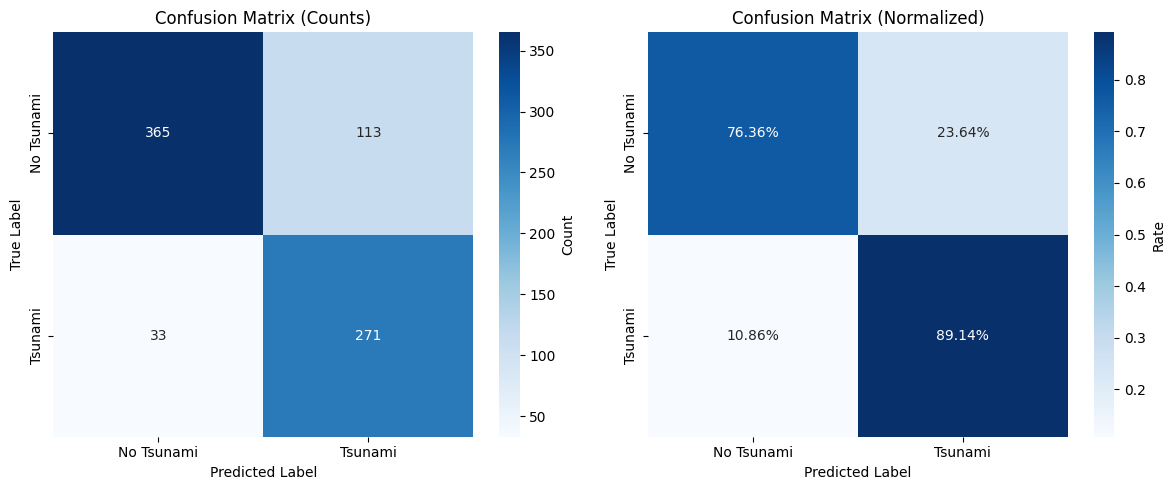

In [14]:
y_pred_cv = cross_val_predict(pipeline, X, y, cv=skf, n_jobs=-1)

cm = confusion_matrix(y, y_pred_cv)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_xticklabels(['No Tsunami', 'Tsunami'])
axes[0].set_yticklabels(['No Tsunami', 'Tsunami'])

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1], cbar_kws={'label': 'Rate'})
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
axes[1].set_xticklabels(['No Tsunami', 'Tsunami'])
axes[1].set_yticklabels(['No Tsunami', 'Tsunami'])

plt.tight_layout()
plt.show()

In [15]:
results_dir = Path("../models")
results_dir.mkdir(parents=True, exist_ok=True)
results_csv = results_dir / "model_results.csv"

In [16]:
logistic_results = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model": "Logistic Regression",
    "cv_splits": skf.get_n_splits(),
    "scaler": "StandardScaler",
    "class_weight": "balanced",
    "test_accuracy": cv_results["test_accuracy"].mean(),
    "test_precision": cv_results["test_precision"].mean(),
    "test_recall": cv_results["test_recall"].mean(),
    "test_f1": cv_results["test_f1"].mean(),
    "test_roc_auc": cv_results["test_roc_auc"].mean(),
    "train_accuracy": cv_results["train_accuracy"].mean(),
    "train_precision": cv_results["train_precision"].mean(),
    "train_recall": cv_results["train_recall"].mean(),
    "train_f1": cv_results["train_f1"].mean(),
    "train_roc_auc": cv_results["train_roc_auc"].mean(),
    "train_test_gap_accuracy": cv_results["train_accuracy"].mean() - cv_results["test_accuracy"].mean(),
    "notes": ""
}

In [17]:
new_results_df = pd.DataFrame([logistic_results])
if results_csv.exists():
    existing_results = pd.read_csv(results_csv)
    model_comparison = pd.concat([existing_results, new_results_df], ignore_index=True)
    model_comparison.to_csv(results_csv, index=False)
else:
    new_results_df.to_csv(results_csv, index=False)
    
new_results_df

,timestamp,model,cv_splits,scaler,class_weight,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc,train_test_gap_accuracy,notes
0,2025-10-14 17:01:27,Logistic Regression,5,StandardScaler,balanced,0.813294,0.709979,0.891421,0.78925,0.827531,0.815856,0.706376,0.901322,0.79197,0.831413,0.002562,


## Model 1: Logistic Regression Results

**Key Findings:**
- **Test Recall: 89.14%** - Successfully detects ~9 out of 10 tsunamis
- **Test Precision: 71.00%** - ~3 out of 10 tsunami predictions are false alarms
- **ROC-AUC: 82.75%** - Good class separation
- **No overfitting** - Train/test gaps all <1%

**Feature Insights:**
- `nst` (number of stations) is the dominant predictor (-1.84 coefficient)
- `magnitude` has positive contribution despite weak correlation in EDA
- Geographic features (lat/lon) have minimal impact

**Next Steps:**
- Try tree-based models that can capture nonlinear interactions
- Engineer magnitude×depth interaction feature
- Consider log-transforms for skewed features (nst, dmin, gap)